In [1]:
import numpy as np
import tensorflow as tf
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
# Depending on the classification model use, we might need to import other packages.
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from datasets import DatasetUCI
from envs import LalEnvFirstAccuracy
from helpers import Minibatch, ReplayBuffer
from dqn import DQN
from Test_AL import policy_rl
import matplotlib.pyplot as plt
import random

import shutil
import os

from scipy.interpolate import make_interp_spline, BSpline

/home/lazaioan/anaconda3/envs/RLA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lazaioan/anaconda3/envs/RLA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lazaioan/anaconda3/envs/RLA/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lazaioan/anaconda3/envs/RLA/lib/python3.6/s

Parameters for dataset and model.

- australian: 690
- breast_cancer: 263
- diabetis: 768
- flare_solar: 144
- german: 1000
- heart: 270
- mushrooms: 8124
- waveform: 5000
- wdbc: 569

In [2]:
N_STATE_ESTIMATION = 30
SIZE = -1
SUBSET = -1 # -1 for using all data points, 0 for even, 1 for odd.
N_JOBS = 1 # Can set more if we want to parallelise.
# Remove the dataset that will be used for testing.
# ['australian', 'breast_cancer', 'diabetis', 'flare_solar', 'german', 'heart', 'mushrooms', 'waveform', 'wdbc']
# possible_dataset_names = ['breast_cancer', 'diabetis', 'flare_solar', 'german', 'heart', 'mushrooms', 'waveform', 'wdbc']
possible_dataset_names = ['mushrooms']
test_dataset_names = ['waveform']
# The quality is measured according to a given quality measure "quality_method". 
QUALITY_METHOD = metrics.accuracy_score

In [3]:
cwd = os.getcwd() # Find current directory.

# Delete following directories if they exist.
shutil.rmtree(cwd+'/__pycache__', ignore_errors=True)
shutil.rmtree(cwd+'/agents', ignore_errors=True)
shutil.rmtree(cwd+'/AL_results', ignore_errors=True)
shutil.rmtree(cwd+'/checkpoints', ignore_errors=True)
shutil.rmtree(cwd+'/summaries', ignore_errors=True)
shutil.rmtree(cwd+'/Output images', ignore_errors=True)

Initialise a dataset that will contain a sample of datapoint from one the indicated classes.

In [4]:
dataset = DatasetUCI(possible_dataset_names, n_state_estimation=N_STATE_ESTIMATION, subset=SUBSET, size=SIZE)
# If we want to measure test error along with training.
dataset_test = DatasetUCI(test_dataset_names, n_state_estimation=N_STATE_ESTIMATION, subset=SUBSET, size=SIZE)
# dataset_test: Diabetis datasets consists of 768 data.

In [5]:
model = LogisticRegression(n_jobs=N_JOBS)

Initialise the environment.

In [6]:
env = LalEnvFirstAccuracy(dataset, model, quality_method=QUALITY_METHOD)
env_test = LalEnvFirstAccuracy(dataset_test, model, quality_method=QUALITY_METHOD)
tf.reset_default_graph()

Parameters for training RL.

In [7]:
DIRNAME = './agents/' # The resulting agent of this experiment will be written in a file.

# Adaptive batch size parameters.
MAX_BATCH = 20 # Maximum batch size per iteration.
BATCH_STEP = 2
POSITIVE_REWARD_INCREASE_BATCH = False # If True, batch size is increased if the reward is positive, thus if ACC is increasing.

# Replay buffer parameters.
REPLAY_BUFFER_SIZE = 1e4
PRIOROTIZED_REPLAY_EXPONENT = 3

# Agent parameters.
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
TARGET_COPY_FACTOR = 0.01
BIAS_INITIALIZATION = 0 # Default 0 # will be set to minus half of average duration during warm start experiments.

# Warm start parameters.
WARM_START_EPISODES = 3 # Reduce for test.
NN_UPDATES_PER_WARM_START = 100

# Episode simulation parameters.
EPSILON_START = 1
EPSILON_END = 0.1
EPSILON_STEPS = 1000

# Training parameters.
TRAINING_EPOCHS = 5 # Reduce for test.
TRAINING_EPISODES_PER_EPOCH = 3 # At each training iteration x episodes are simulated.
NN_UPDATES_PER_EPOCHS = 60 # At each training iteration x gradient steps are made.

# Validation and test parameters.
VALIDATION_EPISODES = 3 # Reduce for test.
TESTING_EPISODES = 3 # Reduce for test.
VALIDATION_TESTING_FREQUENCY = 1 # Every x epochs, validation and test are performed.

Initialise replay buffer.

In [8]:
replay_buffer = ReplayBuffer(buffer_size=REPLAY_BUFFER_SIZE, prior_exp=PRIOROTIZED_REPLAY_EXPONENT)

Warm-start the replay buffer with random episodes. 

Collect episodes.

In [9]:
# Keep track of episode duration to compute average.
episode_durations = []
episode_scores = []
episode_number = 1

for _ in range(WARM_START_EPISODES):
    
    print("Episode {}.".format(episode_number))
    # Reset the environment to start a new episode.
    # The classifier_state contains vector representation of state of the environment (depends on the classifier).
    # The next_action contains vector representations of all actions available to be taken at the next step.
    state, next_action, reward = env.reset()
    done = False
    episode_duration = 6

    # Before we reach a terminal state, make steps.
    while not done:

        # Choose a random action.
        batch = random.randint(1,MAX_BATCH)
        if batch > env.n_actions:
            done = True
            break

        # Getting numbers from 0 to n_actions.
        inputNumbers =range(0,env.n_actions)

        # Non-repeating using sample() function.
        a = np.array(random.sample(inputNumbers, batch))
        action = next_action[:,a]
        next_state, next_action, reward, done = env.step(a)
        # Store the transition in the replay buffer.
        buffer_action = []
        for _ in range(MAX_BATCH):
            buffer_action.append([0,0,0])
        for i in range(len(action.T)):
            buffer_action[i]=action.T[0]
        replay_buffer.store_transition(state, buffer_action, reward, next_state, next_action, done)
        # Get ready for next step.
        state = next_state

        episode_duration += batch

    episode_final_acc = env.return_episode_qualities()
    episode_scores.append(episode_final_acc[-1])    
    episode_durations.append(episode_duration)
    episode_number+=1

# Compute the average episode duration of episodes generated during the warm start procedure.
av_episode_duration = np.mean(episode_durations)
BIAS_INITIALIZATION = -av_episode_duration/2

Episode 1.
Episode 2.
Episode 3.


Plots for warm-start episodes.

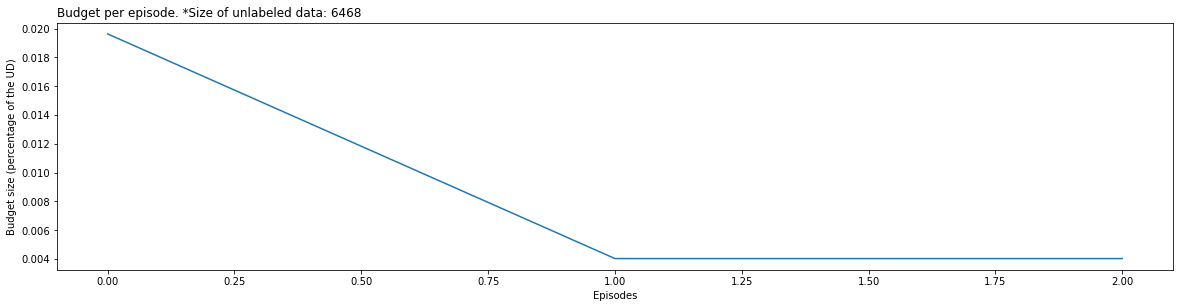

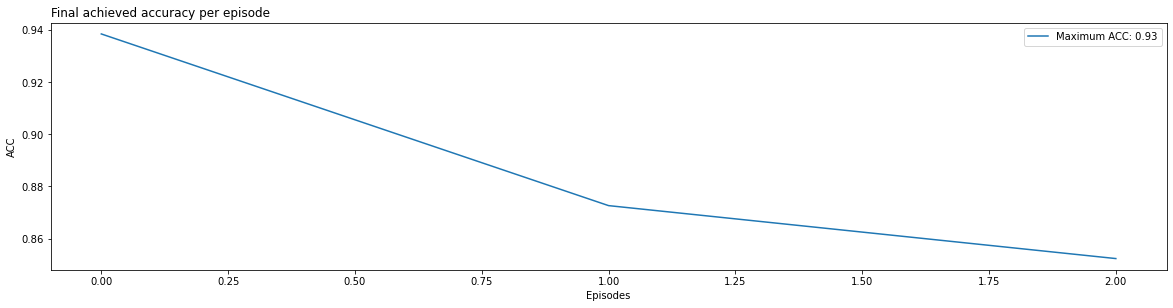

In [10]:
# Plot total budget size per episode.
# Total number of episodes: 100.
xpoints = np.array(range(0,len(episode_durations)))
ypoints = np.array([x/len(dataset.train_data) for x in episode_durations])
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
plt.plot(xpoints, ypoints)
plot_label = "Budget per episode. *Size of unlabeled data: " + str(len(dataset.train_data))
plt.title(plot_label, loc = "left")
plt.xlabel("Episodes")
plt.ylabel("Budget size (percentage of the UD)")

# Plot final achieved accuracy per episode.
# Total number of episodes: 100.
xpoints = np.array(range(0,len(episode_scores)))
ypoints = np.array(episode_scores)
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 2)
plt.plot(xpoints, ypoints)
plt.title("Final achieved accuracy per episode", loc = "left")
plt.xlabel("Episodes")
plt.ylabel("ACC")
legend_label = "Maximum ACC: " + str(max(episode_scores))[:4]
plt.legend([legend_label]) 

plt.show()

Initialize the DQN agent.

In [11]:
agent = DQN(experiment_dir=DIRNAME,
            observation_length=N_STATE_ESTIMATION,
            learning_rate=LEARNING_RATE,
            batch_size=BATCH_SIZE,
            target_copy_factor=TARGET_COPY_FACTOR,
            bias_average=BIAS_INITIALIZATION,
            max_batch=MAX_BATCH,
           )


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Do updates of the network based on warm start episodes.

In [12]:
for _ in range(NN_UPDATES_PER_WARM_START):
    
    # Sample a batch from the replay buffer proportionally to the probability of sampling.
    minibatch = replay_buffer.sample_minibatch(BATCH_SIZE)

    # Use batch to train an agent. Keep track of temporal difference errors during training.
    td_error = agent.train(minibatch)

    # Update probabilities of sampling each datapoint proportionally to the error.
    replay_buffer.update_td_errors(td_error, minibatch.indices)

# Train RL

Run multiple training iterations. Each iteration consists of:
- Generating episodes following agent's actions with exploration.
- Validation and test episodes for evaluating performance.
- Q-network updates.

In [13]:
is_training = True
final_episode_scores_training = []
final_episode_durations_training = []
final_episode_scores_validation = []
final_episode_durations_validation = []
final_episode_scores_testing = []
final_episode_durations_testing = []
validation_and_testing_round = 0

for epoch in range(TRAINING_EPOCHS):

    print("EPOCH {}.".format(epoch+1))
    
    # GENERATE NEW EPISODES.
    print("\n")
    print("TRAINING")

    # Compute epsilon value according to the schedule.
    epsilon = max(EPSILON_END, EPSILON_START-epoch*(EPSILON_START-EPSILON_END)/EPSILON_STEPS)

    # Simulate training episodes.
    episode_scores_training = []
    episode_durations_training = []
    episode_duration = 6

    for training_episode in range(TRAINING_EPISODES_PER_EPOCH):
        
        print("Training episode:", training_episode+1)
        # Reset the environment to start a new episode.
        state, next_action, reward = env.reset()
        batch = 6
        done = False
        done = False
        
        # Run an episode.
        while not done:
            train_batch = batch
            train_batch = env._find_batch_size(batch=train_batch, reward=reward, n_actions=env.n_actions, max_batch=MAX_BATCH, batch_step=BATCH_STEP, positive_reward_increase_batch=POSITIVE_REWARD_INCREASE_BATCH)
            if train_batch > env.n_actions:
                done = True
                break
            episode_duration += train_batch
            action = agent.get_action(state, next_action, train_batch)
            if np.random.ranf() < epsilon:
                batch = random.randint(1,MAX_BATCH)
                inputNumbers =range(0,env.n_actions)
                action = np.array(random.sample(inputNumbers, batch))

            # With epsilon probability, take a random action.
            # taken_action is a vector that corresponds to a taken action.
            taken_action = next_action[:,action]

            # Make another step.
            next_state, next_action, reward, done = env.step(action)

            # Store a step in replay buffer.
            buffer_action = []
            for _ in range(MAX_BATCH):
                buffer_action.append([0,0,0])
            for i in range(len(taken_action.T)):
                buffer_action[i]=taken_action.T[0]
            replay_buffer.store_transition(state, buffer_action, reward, next_state, next_action, done)
            # Change a state of environment.
            state = next_state
            episode_duration += train_batch

        episode_accuracies_training = env.return_episode_qualities()
        episode_scores_training.append(episode_accuracies_training[-1])
        episode_durations_training.append(episode_duration)
    final_episode_durations_training.append(episode_durations_training)
    final_episode_scores_training.append(episode_scores_training)

    # VALIDATION AND TEST EPISODES.
    if epoch%VALIDATION_TESTING_FREQUENCY == 0:
        
        validation_and_testing_round+=1
        print("\n")
        print("VALIDATION AND TESTING ROUND: ", validation_and_testing_round)

        # Validation episodes are run. Use env for it.
        print("\n")
        print("VALIDATION")
        episode_scores_validation = []
        episode_durations_validation = []
        for validation_episode in range(VALIDATION_EPISODES):
            print("Validation episode:", validation_episode)
            episode_duration = 6
            validation_batch = 6
            done = False
            state, next_action, reward = env.reset()
            while not(done):
                validation_batch = env._find_batch_size(batch=validation_batch, reward=reward, n_actions=env.n_actions, max_batch=MAX_BATCH, batch_step=BATCH_STEP, positive_reward_increase_batch=POSITIVE_REWARD_INCREASE_BATCH)
                if validation_batch > env.n_actions:
                    done = True
                else:
                    action = policy_rl(agent, state, next_action, validation_batch)        
                    next_state, next_action, reward, done = env.step(action)
                    state = next_state
                episode_duration += validation_batch
            episode_accuracies_validation = env.return_episode_qualities()
            episode_scores_validation.append(episode_accuracies_validation[-1])
            episode_durations_validation.append(episode_duration)
        final_episode_scores_validation.append(episode_scores_validation)
        final_episode_durations_validation.append(episode_durations_validation)
        
        # Test episodes are run. Use env_test for it.
        print("\n")
        print("TESTING")
        episode_scores_testing = []
        episode_durations_testing = []
        for testing_episode in range(TESTING_EPISODES):
            print("Testing episode:", testing_episode)
            episode_duration = 6
            test_batch = 6
            done = False
            state, next_action, reward = env_test.reset()
            while not(done):
                test_batch = env_test._find_batch_size(batch=test_batch, reward=reward, n_actions=env.n_actions, max_batch=MAX_BATCH, batch_step=BATCH_STEP, positive_reward_increase_batch=POSITIVE_REWARD_INCREASE_BATCH)
                if test_batch > env_test.n_actions:
                    done = True
                else:
                    action = policy_rl(agent, state, next_action, test_batch)       
                    next_state, next_action, reward, done = env_test.step(action)
                    state = next_state
                episode_duration += test_batch
            episode_accuracies_testing = env_test.return_episode_qualities()
            episode_scores_testing.append(episode_accuracies_testing[-1])
            episode_durations_testing.append(episode_duration)
        final_episode_scores_testing.append(episode_scores_testing)
        final_episode_durations_testing.append(episode_durations_testing)

    # NEURAL NETWORK UPDATES.
    for _ in range(NN_UPDATES_PER_EPOCHS):
        minibatch = replay_buffer.sample_minibatch(BATCH_SIZE)
        td_error = agent.train(minibatch)
        replay_buffer.update_td_errors(td_error, minibatch.indices)

EPOCH 1.


TRAINING
Training episode: 1


TRAINING
Training episode: 2


TRAINING
Training episode: 3


VALIDATION AND TESTING ROUND:  1


VALIDATION
Validation episode: 0


VALIDATION
Validation episode: 1


VALIDATION
Validation episode: 2


TESTING
Testing episode: 0


TESTING
Testing episode: 1


TESTING
Testing episode: 2
EPOCH 2.


TRAINING
Training episode: 1


TRAINING
Training episode: 2


TRAINING
Training episode: 3


VALIDATION AND TESTING ROUND:  2


VALIDATION
Validation episode: 0


VALIDATION
Validation episode: 1


VALIDATION
Validation episode: 2


TESTING
Testing episode: 0


TESTING
Testing episode: 1


TESTING
Testing episode: 2
EPOCH 3.


TRAINING
Training episode: 1


TRAINING
Training episode: 2


TRAINING
Training episode: 3


VALIDATION AND TESTING ROUND:  3


VALIDATION
Validation episode: 0


VALIDATION
Validation episode: 1


VALIDATION
Validation episode: 2


TESTING
Testing episode: 0


TESTING
Testing episode: 1


TESTING
Testing episode: 2
EPOCH 4.


TR

- Total number of validation and testing epochs: 10
- Total number of episodes per validation and testing epochs: 500

#### Plots.

In [14]:
# Create the folder to store the results from the experiments.
results_path = r'./Output images' 
if not os.path.exists(results_path):
    os.makedirs(results_path)

Maximum accuracy per epoch.

In [15]:
# Find the maximum accuracy per training epoch (each epoch consists of 10 episodes)
# and their respective budgets.
max_training_score_per_epoch = []
budgets = []
budgets_for_max_scores = []
for i in range(len(final_episode_scores_training)):
    max_score = max(final_episode_scores_training[i])
    for j in range(len(final_episode_scores_training[i])):
        if final_episode_scores_training[i][j]==max_score:
            budgets.append(final_episode_durations_training[i][j])
    budget_for_max_score = np.array(budgets).min()
    max_training_score_per_epoch.append(max_score)
    budgets_for_max_scores.append(budget_for_max_score)

# Print maximum ACC.
print("The maximum accuracy is {}.".format(max(max_training_score_per_epoch)))

# Print smallest budget for the maximum ACC.
max_ACC = max(max_training_score_per_epoch)
min_budget = []
for i in range(len(max_training_score_per_epoch)):
    if max_training_score_per_epoch[i] == max_ACC:
        min_budget.append(budgets_for_max_scores[i])
print("The budget for the maximum accuracy is {}.".format(np.array(min_budget).min()))

The maximum accuracy is 0.9273846153846154.
The budget for the maximum accuracy is 46.


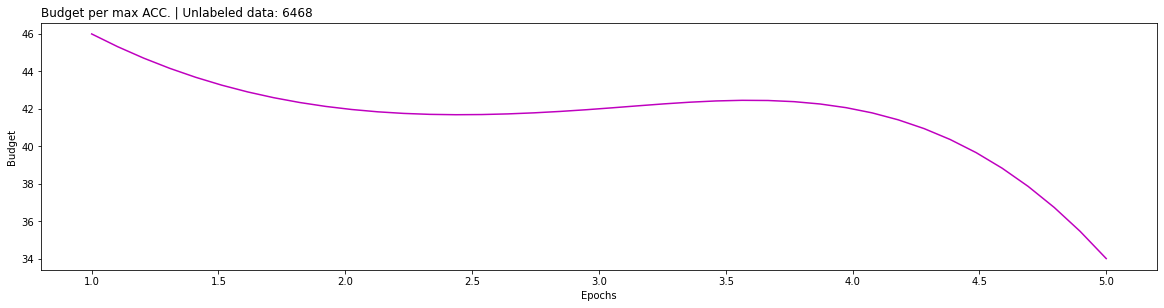

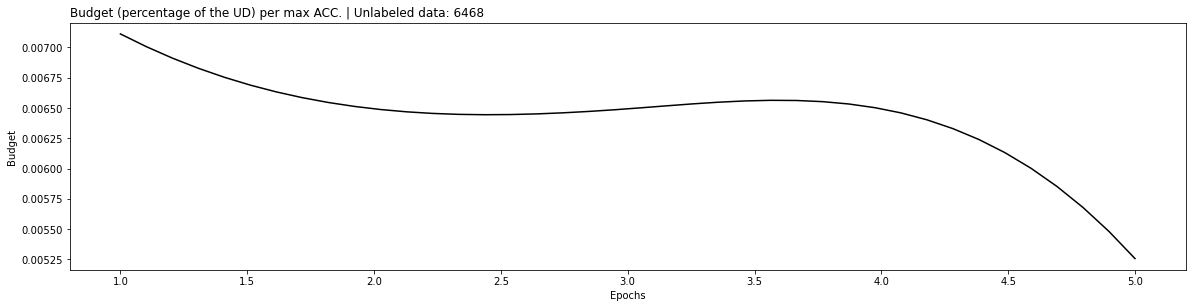

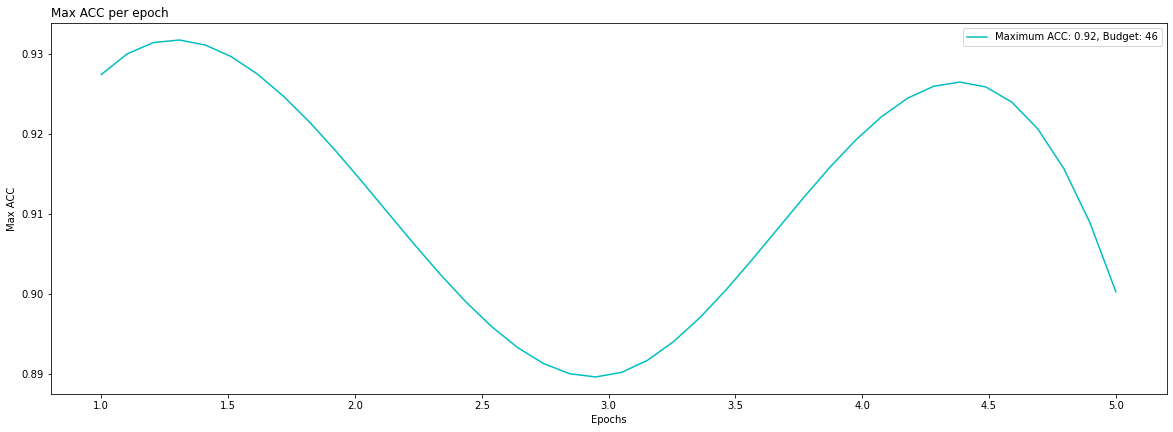

In [16]:
# Plot maximum achieved accuracy per epoch and the respective budgets.
# Total number of iterations (epochs): 1000.
# Total number of episodes per epoch: 10.

xpoints = np.array(range(1,len(budgets_for_max_scores)+1))
ypoints = np.array(budgets_for_max_scores)
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='m')
plot_label = "Budget per max ACC. | Unlabeled data: " + str(len(dataset.train_data))
plt.title(plot_label, loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Budget")
plt.savefig("Output images/TRAINING, Budget.png")

xpoints = np.array(range(1,len(budgets_for_max_scores)+1))
ypoints = np.array([x/len(dataset.train_data) for x in budgets_for_max_scores])
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='k')
plot_label = "Budget (percentage of the UD) per max ACC. | Unlabeled data: " + str(len(dataset.train_data))
plt.title(plot_label, loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Budget")
plt.savefig("Output images/TRAINING, Budget percentage.png")

xpoints = np.array(range(1,len(max_training_score_per_epoch)+1))
ypoints = np.array(max_training_score_per_epoch)
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 2)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='c')
plt.title("Max ACC per epoch", loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Max ACC")
legend_1 = "Maximum ACC: " + str(np.array(max_training_score_per_epoch).max())[:4]
legend_2 = ", "
legend_3 = "Budget: " + str(np.array(min_budget).min())[:4]
plt.legend([legend_1 + legend_2 + legend_3])
plt.savefig("Output images/TRAINING, Max ACC.png")

plt.show()

Plots for validation episodes.

In [17]:
# Find the maximum accuracy per validation epoch and their respective budgets.
max_validation_score_per_epoch = []
budgets = []
budgets_for_max_scores = []
for i in range(len(final_episode_scores_validation)):
    max_score = max(final_episode_scores_validation[i])
    for j in range(len(final_episode_scores_validation[i])):
        if final_episode_scores_validation[i][j]==max_score:
            budgets.append(final_episode_durations_validation[i][j])
    budget_for_max_score = np.array(budgets).min()
    max_validation_score_per_epoch.append(max_score)
    budgets_for_max_scores.append(budget_for_max_score)

# Print maximum ACC.
print("The maximum accuracy is {}.".format(max(max_validation_score_per_epoch)))

# Print smallest budget for the maximum ACC.
max_ACC = max(max_validation_score_per_epoch)
min_budget = []
for i in range(len(max_validation_score_per_epoch)):
    if max_validation_score_per_epoch[i] == max_ACC:
        min_budget.append(budgets_for_max_scores[i])
print("The budget for the maximum accuracy is {}.".format(np.array(min_budget).min()))

The maximum accuracy is 0.9193846153846154.
The budget for the maximum accuracy is 12.


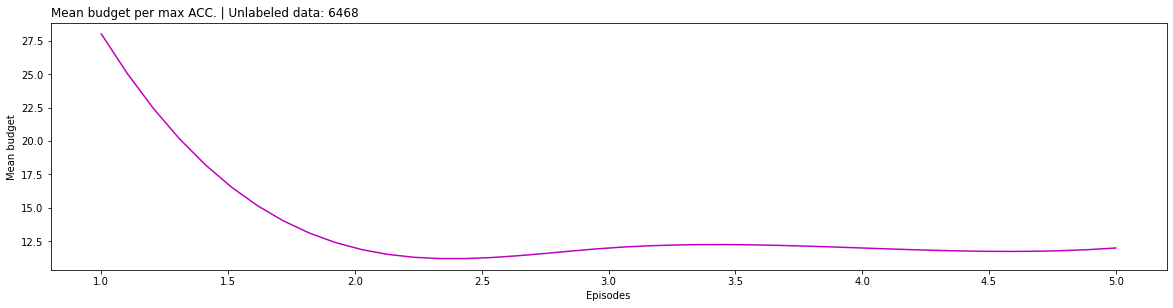

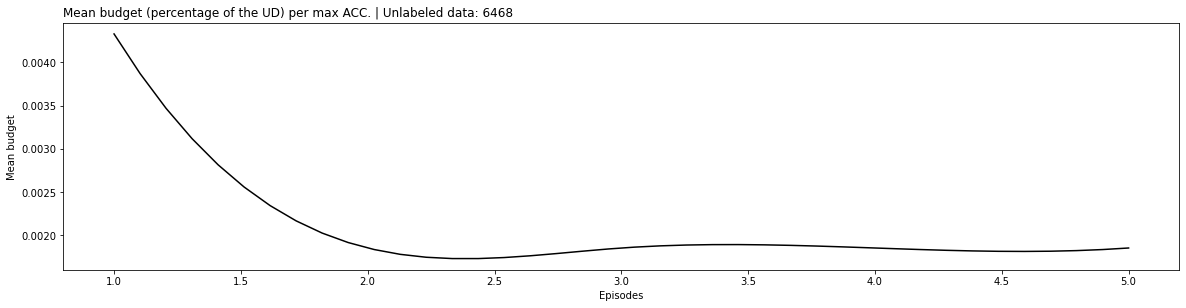

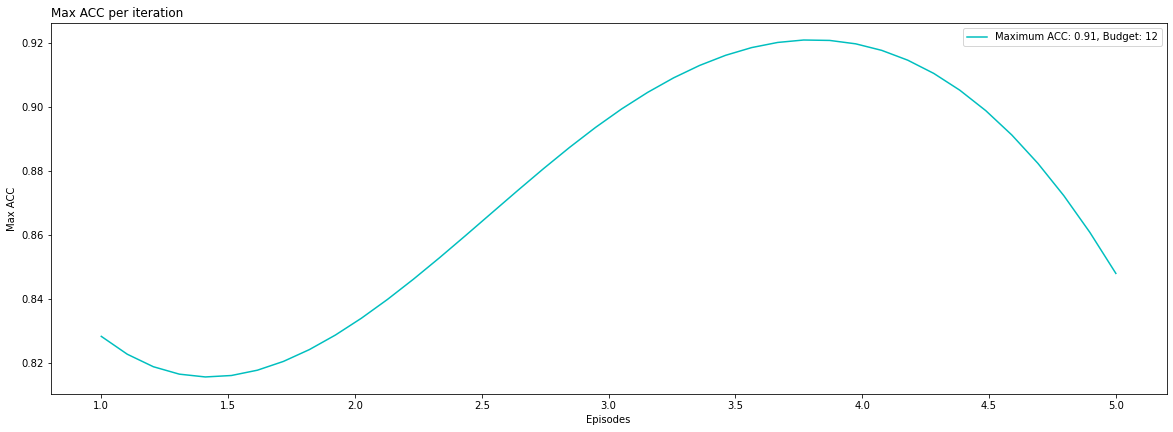

In [21]:
# Plot maximum achieved accuracy per validation iteration and the respective budgets.
# Total number of iterations (epochs): 10.
# Total number of episodes per iteration: 500.

xpoints = np.array(range(1,len(budgets_for_max_scores)+1))
ypoints = np.array(budgets_for_max_scores)
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='m')
plot_label = "Budget per max ACC. | Unlabeled data: " + str(len(dataset.train_data))
plt.title(plot_label, loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Mean budget")

xpoints = np.array(range(1,len(budgets_for_max_scores)+1))
ypoints = np.array([x/len(dataset.train_data) for x in budgets_for_max_scores])
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='k')
plot_label = "Budget (percentage of the UD) per max ACC. | Unlabeled data: " + str(len(dataset.train_data))
plt.title(plot_label, loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Mean budget")

xpoints = np.array(range(1,len(max_validation_score_per_epoch)+1))
ypoints = np.array(max_validation_score_per_epoch)
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 2)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='c')
plt.title("Max ACC per iteration", loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Max ACC")
legend_1 = "Maximum ACC: " + str(np.array(max_validation_score_per_epoch).max())[:4]
legend_2 = ", "
legend_3 = "Budget: " + str(np.array(min_budget).min())[:4]
plt.legend([legend_1 + legend_2 + legend_3])

plt.show()

Plots for testing episodes.

In [19]:
# Find the maximum accuracy per testing epoch and their respective budgets.
max_testing_score_per_epoch = []
budgets = []
budgets_for_max_scores = []
for i in range(len(final_episode_scores_testing)):
    max_score = max(final_episode_scores_testing[i])
    for j in range(len(final_episode_scores_testing[i])):
        if final_episode_scores_testing[i][j]==max_score:
            budgets.append(final_episode_durations_testing[i][j])
    budget_for_max_score = np.array(budgets).min()
    max_testing_score_per_epoch.append(max_score)
    budgets_for_max_scores.append(budget_for_max_score)

# Print maximum ACC.
print("The maximum accuracy is {}.".format(max(max_testing_score_per_epoch)))

# Print smallest budget for the maximum ACC.
max_ACC = max(max_testing_score_per_epoch)
min_budget = []
for i in range(len(max_testing_score_per_epoch)):
    if max_testing_score_per_epoch[i] == max_ACC:
        min_budget.append(budgets_for_max_scores[i])
print("The budget for the maximum accuracy is {}.".format(np.array(min_budget).min()))

The maximum accuracy is 0.853.
The budget for the maximum accuracy is 12.


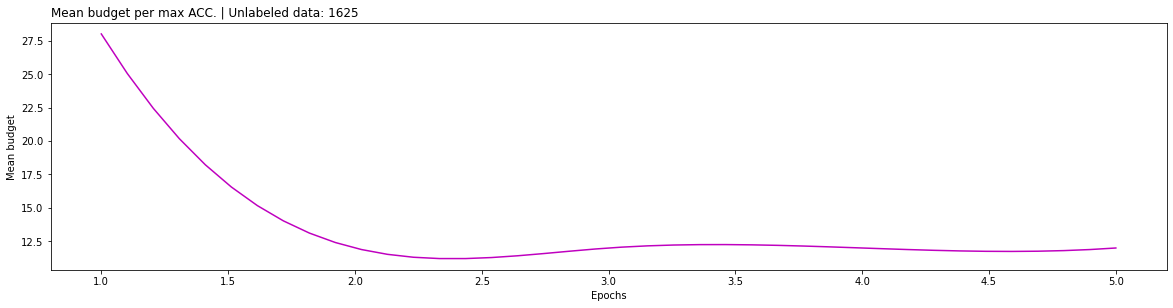

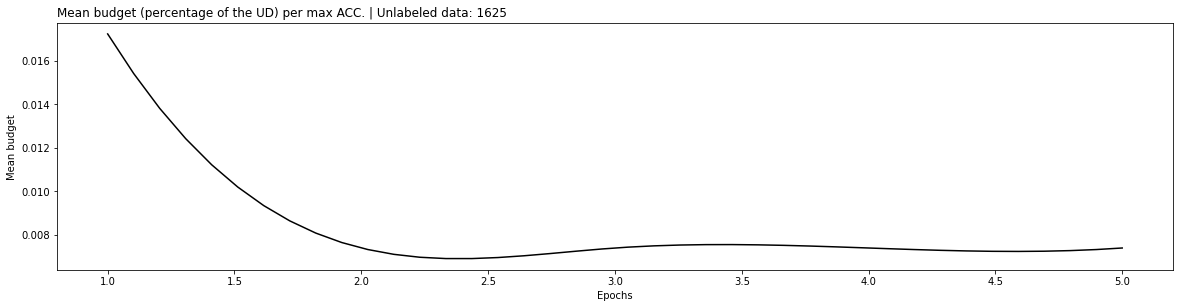

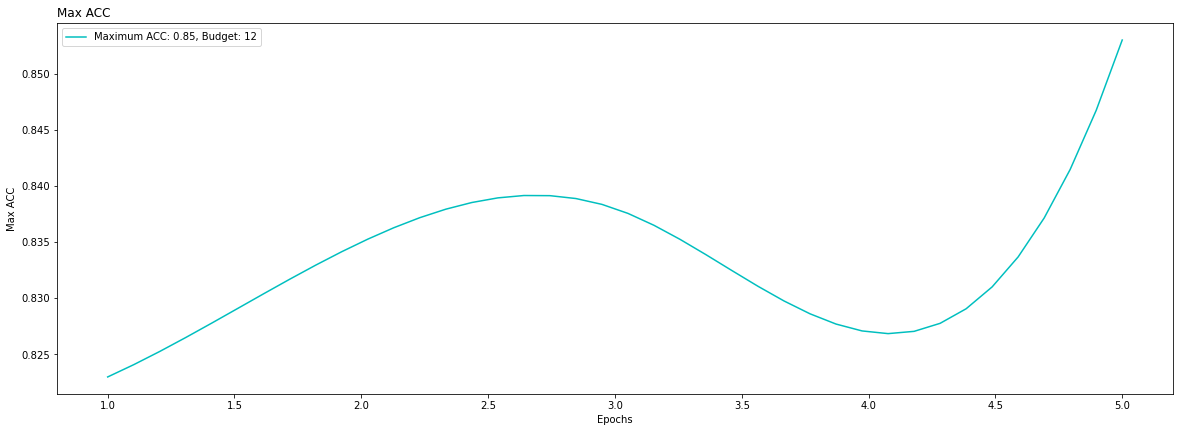

In [23]:
# Plot maximum achieved accuracy per testing iteration and the respective budgets.
# Total number of iterations (epochs): 10.
# Total number of episodes per iteration: 500.

xpoints = np.array(range(1,len(budgets_for_max_scores)+1))
ypoints = np.array(budgets_for_max_scores)
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='m')
plot_label = "Budget per max ACC. | Unlabeled data: " + str(len(dataset.test_data))
plt.title(plot_label, loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Mean budget")

xpoints = np.array(range(1,len(budgets_for_max_scores)+1))
ypoints = np.array([x/len(dataset.test_data) for x in budgets_for_max_scores])
plt.figure(figsize=(20,10))
plt.subplot(2, 1, 1)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='k')
plot_label = "Budget (percentage of the UD) per max ACC. | Unlabeled data: " + str(len(dataset.test_data))
plt.title(plot_label, loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Mean budget")

xpoints = np.array(range(1,len(max_testing_score_per_epoch)+1))
ypoints = np.array(max_testing_score_per_epoch)
plt.figure(figsize=(20,15))
plt.subplot(2, 1, 2)
xnew = np.linspace(xpoints.min(), xpoints.max(), 40)
spl = make_interp_spline(xpoints, ypoints, k=3)
power_smooth = spl(xnew)
plt.plot(xnew, power_smooth, color='c')
plt.title("Max ACC", loc = "left")
plt.xlabel("Epochs")
plt.ylabel("Max ACC")
legend_1 = "Maximum ACC: " + str(np.array(max_testing_score_per_epoch).max())[:4]
legend_2 = ", "
legend_3 = "Budget: " + str(np.array(min_budget).min())[:4]
plt.legend([legend_1 + legend_2 + legend_3])

plt.show()